# T2 Zeiten für LMO Probe

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

In [2]:
from func import fit_t2
import file_organizer as fo

## multiple meas: meas == F

In [3]:
# import file list and select files
path = 'data_day_one'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','F'))

# load data to pd.dataFrame
data = fo.load_files(selection)
data = fo.df_combine(data)
# data.info()
del(data['iout'])
del(data['qout'])

# extract parameter (label, tau)
label = list(data.columns)
label.remove('time')
tau = np.array([meas.tau for meas in selection])*1000 

In [4]:
from lmfit import Model
def fit_t2(t, y, log=False):
    def t2func(t, M0, T2, const):#
        return M0*np.exp(-t/T2)+const

    model = Model(t2func, nan_policy='omit')
    res = model.fit(y, t=t, M0=1, T2=0.02, const=0)
    if log: print(res.fit_report())
    return res

In [5]:
# peak-finding
peaks = [find_peaks(data[l], height=2, distance=40, width=10)[0] for l in label]
idx = [peaks[0][0]] + [p[1] for p in peaks[1:]]
times = data['time'][idx]
values = np.array([data.loc[i, l] for i,l in zip(idx, label)])

# use fit-function from another file
result = fit_t2(times[1:], values[1:], log=True)
t2 = result.params['T2']

[[Model]]
    Model(t2func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 20
    # variables        = 3
    chi-square         = 1.05242075
    reduced chi-square = 0.06190710
    Akaike info crit   = -52.8927858
    Bayesian info crit = -49.9055890
[[Variables]]
    M0:     17.3426875 +/- 0.40522077 (2.34%) (init = 1)
    T2:     0.05603593 +/- 0.00380451 (6.79%) (init = 0.02)
    const: -1.24206381 +/- 0.51753213 (41.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(T2, const) = -0.971
    C(M0, const) = -0.897
    C(M0, T2)    = 0.788


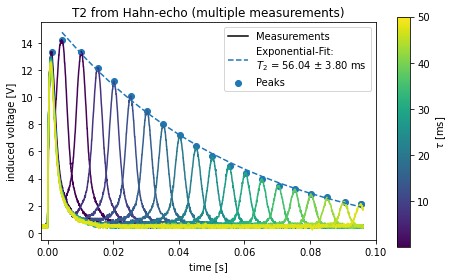

In [6]:
fig,ax=plt.subplots()
ran = slice(0, 20,1) # reduce lines
# fancy-color-nonsens
from func import get_norm_cm
colormap, m, n = get_norm_cm('viridis', min(tau), max(tau))
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb1 = mpl.colorbar.ColorbarBase(ax=ax2, cmap=m,norm=n)
ax2.set_ylabel('$\\tau$ [ms]')

# plot data
for l, t, in zip(label[ran], tau[ran]):
    data.plot(x='time', y=l, ax=ax, label='', color=colormap(t))
ax.plot([],[], label='Measurements', color='black')
ax.scatter(times, values, label='Peaks')
ax.plot(times[1:], result.best_fit, '--', 
    label=f'Exponential-Fit:\n$T_2$ = {t2.value*1000 :.2f} $\pm$ {t2.stderr*1000:.2f} ms ')


ax.legend().remove()
ax.set_xlabel('time [s]')
ax.set_ylabel('induced voltage [V]')
ax.set_xlim(-0.002,0.1)
ax.set_title('T2 from Hahn-echo (multiple measurements)')
ax.legend()
plt.show()


## meas == 

In [ ]:
# load file list and select
path = 'data_day_one'
file_list = fo.load_file_list(path)
# Meiboom-Gill
selection = (fo.select_files(file_list,'meas','G1'))
data1 = fo.load_files(selection)
# carr pucell
selection2 = fo.select_files(file_list, 'meas', 'G2')
data2 = fo.load_files(selection2)
data = fo.df_combine(data2+data1)

In [ ]:
# prep data
del(data['iout'])
del(data['qout'])
# data['time'] = data['time'] * 1000
labels = list(data.columns)
labels.remove('time')
data.info()

# find peaks
peaks = [find_peaks(data[l], distance=40, height=1)[0] for l in labels]

# calc fits
times = [data.loc[p,'time'] for p in peaks]
values = [data.loc[p, l] for l,p in zip(labels, peaks)]
results = [fit_t2(time, value, log=False) 
           for time,value in zip(times, values)]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       2000 non-null   float64
 1   signal_79  2000 non-null   float64
 2   signal_80  2000 non-null   float64
 3   signal_77  2000 non-null   float64
 4   signal_78  2000 non-null   float64
dtypes: float64(5)
memory usage: 78.2 KB


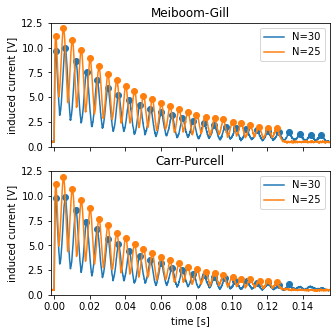

<Parameter 'T2', value=0.047816489353612796 +/- 0.00217, bounds=[-inf:inf]>
<Parameter 'T2', value=0.05416244328929854 +/- 0.00369, bounds=[-inf:inf]>
<Parameter 'T2', value=0.04701105796792188 +/- 0.00255, bounds=[-inf:inf]>
<Parameter 'T2', value=0.052058219531637 +/- 0.00326, bounds=[-inf:inf]>


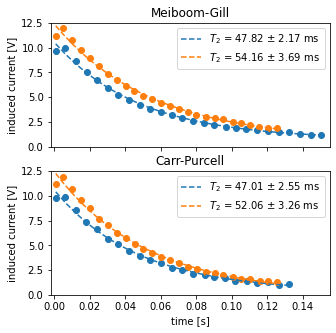

[299     0.0009
352     0.0062
413     0.0123
473     0.0183
533     0.0243
593     0.0303
652     0.0362
713     0.0423
772     0.0482
832     0.0542
894     0.0604
954     0.0664
1011    0.0721
1071    0.0781
1132    0.0842
1192    0.0902
1255    0.0965
1312    0.1022
1372    0.1082
1431    0.1141
1492    0.1202
1554    0.1264
1614    0.1324
1673    0.1383
1734    0.1444
1792    0.1502
Name: time, dtype: float64, 299     0.0009
342     0.0052
392     0.0102
442     0.0152
493     0.0203
543     0.0253
592     0.0302
642     0.0352
692     0.0402
740     0.0450
792     0.0502
843     0.0553
892     0.0602
942     0.0652
992     0.0702
1043    0.0753
1091    0.0801
1142    0.0852
1193    0.0903
1243    0.0953
1294    0.1004
1340    0.1050
1393    0.1103
1442    0.1152
1491    0.1201
1542    0.1252
Name: time, dtype: float64, 299     0.0009
352     0.0062
414     0.0124
472     0.0182
532     0.0242
592     0.0302
652     0.0362
711     0.0421
773     0.0483
831     0.0541
894     0.060

In [ ]:

# show data and peaks
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(5,5), sharex=True)
ax1.set_title('Meiboom-Gill')
ax2.set_title('Carr-Purcell')

axis = [ax1,ax1,ax2,ax2]
names = ['N=30', 'N=25']*2
for l, peak, ax,n in zip(labels, peaks, axis, names):
    data.plot(x='time', y=l, ax=ax, label=n)
    ax.scatter(data['time'][peak], data[l][peak])

for ax in [ax1,ax2]:
    ax.set_xlim(-0.002,0.155)
    ax.set_ylim(0,12.5)
    ax.set_ylabel('induced current [V]')
    ax.set_xlabel('time [s]')
    ax.label_outer()
plt.show()


# show peaks and fit
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(5,5), sharex=True)
ax1.set_title('Meiboom-Gill')
ax2.set_title('Carr-Purcell')

axis = [ax1,ax1,ax2,ax2]
for t, v, r, ax in zip(times, values, results, axis):
    ax.scatter(t,v)
    t2 = r.params['T2']
    ax.plot(t, r.best_fit, '--', label=f'$T_2$ = {t2.value*1000 :.2f} $\pm$ {t2.stderr*1000:.2f} ms ')
    print(r.params['T2'])
    ax.legend()
for ax in [ax1,ax2]:
    ax.set_xlim(-0.002,0.155)
    ax.set_ylim(0,12.5)
    ax.set_ylabel('induced current [V]')
    ax.set_xlabel('time [s]')
    ax.label_outer()
plt.show()

print(times)



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>